In [1]:
!python3 -m pip show fastai

Name: fastai
Version: 2.7.10
Summary: fastai simplifies training fast and accurate neural nets using modern best practices
Home-page: https://github.com/fastai/fastai
Author: Jeremy Howard, Sylvain Gugger, and contributors
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /Users/gwilliams/Projects/SEEMAP2023/venv/seemap2023/lib/python3.8/site-packages
Requires: fastcore, fastdownload, fastprogress, matplotlib, packaging, pandas, pillow, pip, pyyaml, requests, scikit-learn, scipy, spacy, torch, torchvision
Required-by: 


In [2]:
import torch
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())
torch.device("mps")

from fastai.vision.all import *
default_device(torch.device("mps"))

from timm import create_model
import timm

from fastai.learner import Learner

False
True


In [3]:
if False:
    #timm.list_models(pretrained=False)

    modelstrs = timm.list_models(pretrained=False)
    for modelstr in modelstrs:
        if modelstr.find("mobilenet")>=0:
            body = create_timm_body(modelstr, pretrained=True)

In [4]:
path = untar_data(URLs.MNIST)
print(path)

/Users/gwilliams/.fastai/data/mnist_png


In [5]:
block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label)
#        batch_tfms=aug_transforms(mult=2., do_flip=False))

In [6]:
loaders = block.dataloaders(path/"training")
#loaders.train.show_batch(max_n=4, nrows=1)

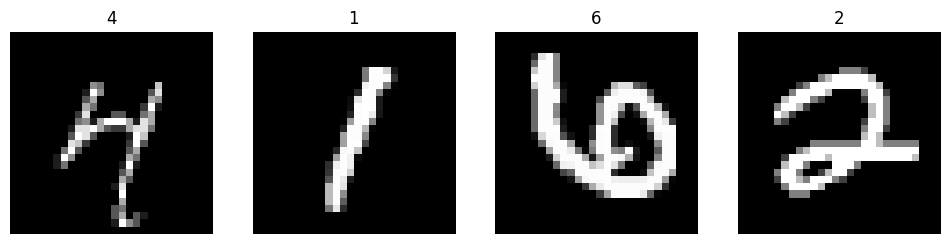

In [7]:
loaders.train.show_batch(max_n=4, nrows=1)

In [ ]:
# squeezenet default fast ai learner
#learn = vision_learner(loaders, squeezenet1_0, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
#learn.summary()

In [ ]:
class Mnist_NN(nn.Module):
    def __init__(self,pretrained):
        super().__init__()
        self.lin1 = nn.Linear(784, 512, bias=True) 
        self.lin2 = nn.Linear(512, 256, bias=True)
        self.lin3 = nn.Linear(256, 10, bias=True)

    def forward(self, xb):
        x = xb.view(-1,784) 
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return self.lin3(x)

In [ ]:
def get_model(model, pretrained=False, progress=True, **kwargs):
    """model: function to load the model, e.g. resnet18
        pretrained, progress: to be passed to the model function
    """
    m = model(pretrained=pretrained, progress=progress, **kwargs) # loads standard model
    ##m.avgpool = nn.AdaptiveAvgPool2d(output_size=(100,100)) # changes one layer
    return m

In [ ]:

from fastai.vision.learner import _update_first_layer
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    try:
        model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
        print(arch, type(model),sum([p.numel() for p in model.parameters()]))
    
        _update_first_layer(model, n_in, pretrained)
        if cut is None:
            ll = list(enumerate(model.children()))
            cut = next(i for i,o in reversed(ll) if has_pool_type(o))
        if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
        elif callable(cut): return cut(model)
        else: raise NamedError("cut must be either integer or function")
    except:
        print("error processing cut")

In [ ]:
body = create_timm_body('mobilenetv3_small_050', pretrained=True)

In [ ]:
nf = num_features_model(nn.Sequential(*body.children())); nf


In [ ]:
head = create_head(nf, loaders.c)

In [ ]:
model = nn.Sequential(body, head)

In [ ]:
apply_init(model[1], nn.init.kaiming_normal_)

In [ ]:
len(model)

In [ ]:
def get_model(model, pretrained=False, progress=True, **kwargs):
    """model: function to load the model, e.g. resnet18
        pretrained, progress: to be passed to the model function
    """
    m = model(pretrained=pretrained, progress=progress, **kwargs) # loads standard model
    ##m.avgpool = nn.AdaptiveAvgPool2d(output_size=(100,100)) # changes one layer
    return m

In [8]:
##learn = vision_learner(loaders, partial(get_model, model=model), loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
learn = vision_learner(loaders, squeezenet1_0, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

##learn = Learner(loaders, model, loss_func=LabelSmoothingCrossEntropy())


/Users/gwilliams/Projects/SEEMAP2023/venv/seemap2023/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gwilliams/Projects/SEEMAP2023/venv/seemap2023/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
learn.summary()

Sequential (Input shape: 64 x 3 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 96 x 11 x 11   
Conv2d                                    14208      False     
ReLU                                                           
____________________________________________________________________________
                     64 x 96 x 5 x 5     
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 16 x 5 x 5     
Conv2d                                    1552       False     
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 5 x 5     
Conv2d                                    1088       False     
ReLU                                                           
Conv2d                                    9280

In [10]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.575967,1.193913,0.867000,01:41


In [11]:
pytorch_model = learn.model.eval()
print(type(pytorch_model))

<class 'torch.nn.modules.container.Sequential'>


In [12]:
torch.save(pytorch_model, "data/fastai_mnist.pt")

In [13]:
pm = torch.load("data/fastai_mnist.pt")

In [14]:
import torchvision.transforms as tfms
def fast2pil(img):
  return tfms.ToPILImage()(img.data).convert("RGB")

In [22]:
b = loaders.one_batch()
print(len(b))
print( type(b[0]), b[0].shape)
print( type(b[1]), b[1].shape)
print( b[1][0] )
o = pm(b[0])
print( type(o), o.shape)
print(o[0])
print(dir(b))
print(type(b[0][0]))
if True:
    img = fast2pil(b[0][0])
    print(type(img))
    display(img)
print(b[1][0])
smax = torch.nn.functional.softmax(o[0])
print(smax)
print(o[0])
m,p = torch.max(smax,-1)
print(p)

2
<class 'fastai.torch_core.TensorImage'> torch.Size([64, 3, 28, 28])
<class 'fastai.torch_core.TensorCategory'> torch.Size([64])
TensorCategory(5)
<class 'fastai.torch_core.TensorBase'> torch.Size([64, 10])
TensorBase([ 2.2706, -2.9245,  0.0870, -1.0103, -0.2144,  2.8094,  2.2570,
            -3.4452, -1.9547, -1.0822], grad_fn=<AliasBackward0>)
['__add__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'count', 'index']
<class 'fastai.torch_core.TensorImage'>
<class 'PIL.Image.Image'>


TensorCategory(5)
TensorBase([0.2505, 0.0014, 0.0282, 0.0094, 0.0209, 0.4293, 0.2471, 0.0008,
            0.0037, 0.0088], grad_fn=<AliasBackward0>)
TensorBase([ 2.2706, -2.9245,  0.0870, -1.0103, -0.2144,  2.8094,  2.2570,
            -3.4452, -1.9547, -1.0822], grad_fn=<AliasBackward0>)
TensorBase(5)


# We have an issue with prediction based on a loader not part of the origina training??

In [23]:
pm = torch.load("data/fastai_mnist.pt")

In [24]:
path = untar_data(URLs.MNIST)
print(path)
block2 = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label)

loaders2 = block2.dataloaders(path/"training")

/Users/gwilliams/.fastai/data/mnist_png


In [45]:
b = loaders.one_batch()
print(type(b[0][0]))
img = fast2pil(b[0][0])
print(type(img))
display(img)
print(b[1][0])
o = pm(b[0])
smax = torch.nn.functional.softmax(o[0])
print(smax)
print(o[0])
m,p = torch.max(smax,-1)
print(p)

<class 'fastai.torch_core.TensorImage'>
<class 'PIL.Image.Image'>


TensorCategory(6)
TensorBase([8.5946e-02, 1.8336e-03, 2.4087e-01, 1.1465e-02, 4.3907e-02,
            7.2856e-03, 5.7593e-01, 5.3010e-04, 2.7779e-02, 4.4553e-03],
           grad_fn=<AliasBackward0>)
TensorBase([ 1.1291e+00, -2.7183e+00,  2.1596e+00, -8.8533e-01,  4.5744e-01,
            -1.3387e+00,  3.0314e+00, -3.9593e+00, -3.6687e-04, -1.8305e+00],
           grad_fn=<AliasBackward0>)
TensorBase(6)


In [42]:
bb = loaders2.one_batch()
print(type(bb[0][0]))
img2 = fast2pil(bb[0][0])
print(type(img2))
display(img2)
print(bb[1][0])
oo = pm(bb[0])
smaxx = torch.nn.functional.softmax(oo[0])
print(smaxx)
print(oo[0])
mm,pp = torch.max(smaxx,-1)
print(pp)

<class 'fastai.torch_core.TensorImage'>
<class 'PIL.Image.Image'>


TensorCategory(1)
TensorBase([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], grad_fn=<AliasBackward0>)
TensorBase([  151.7767,  -358.5115,   716.9222, -1069.2673, -2446.7822,
              968.1915,  -717.2325,  -268.9084,  -985.1187,  -587.1184],
           grad_fn=<AliasBackward0>)
TensorBase(5)
